In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

%matplotlib inline

# 1. Write a script that simulates positive control data

### Note: I've used the hints and some code from the section notes in my code below. Thanks Sean Eddy and TFs for your help!!

In [20]:
def simulator(N, M, R, O):
    '''
    Simulates positive control data based on the parameters below. 
    
    
    Parameters
    ----------
    
    N: integer
        number of genes
    M: integer
        number of different conditions/treatments
    R: integer
        number of gene modules
    O: integer
        number of moonlighting genes
        
    Returns
    -------
    
    W: numpy array
        N x R (genes by module)
    H: numpy array
        R x M (modules by condition)
    V: numpy array
        noisy array of observations for data
    '''
    
    np.random.seed(5)

    #generate a zeros matrix for W
    W = np.zeros((N, R))

    idxs = np.arange(0,N)

    np.random.shuffle(idxs)

    #define which idxs go with which module randomly
    c = 0
    assign = []
    for i in range(R-1):
        j = int(N/R + np.random.randint(-10, 10))
        assign.append(list(idxs[c:j+c]))
        c +=j
    assign.append(list(idxs[c:]))
    
    print("number of genes in each module before moonlighting:")
    for i in assign:
        print(len(i))

    #choose a few genes to assign as mOonlighting genes
    moon = np.random.choice(N, O)
    print("moonlighting genes:")
    print(moon)

    l = []
    print("moonlighting gene assignments")
    for i in moon:
        for j, a in enumerate(assign):
            if i in a:
                k = j + np.random.choice([-1,1])
                if k >= R:
                    k = k - R
                if k < 0:
                    k = k + R
                #k = int(j + np.random.choice([-1,1]))%R
                print(i, j, k)
                l.append(k)

    for w, m in enumerate(moon):
        assign[l[w]].append(m)
    
    print("number of genes in each module after moonlighting:")
    for i in assign:
        print(len(i))

    p = []
    for i, j in enumerate(assign):
        p.append(np.random.dirichlet(np.ones(len(j))))

    for o, f in enumerate(assign):
        for h, i in enumerate(f):
            #print(o, h)
            W[i,o] = p[o][h]
    #generate H
    H = np.ones((R, M))
    H = np.apply_along_axis(np.random.dirichlet, 0, H)
    
    #generate counts list
    C = []
    for i in range(M):
        C.append(100000 + np.random.randint(-10000,10000))
        
    #define lambda
    L = W @ H
    L = L*C

    #add noise
    V = np.random.poisson(L)

    return W, H, V

In [21]:
#vary these parameters to see how they affect the outcomes to compare predictions to true values at end of question 2.
W_1, H_1, V_1 = simulator(100, 60, 5, 5)

number of genes in each module before moonlighting:
21
15
19
15
30
moonlighting genes:
[82 60 91 29 88]
moonlighting gene assignments
82 3 2
60 0 1
91 4 3
29 2 3
88 1 0
number of genes in each module after moonlighting:
22
16
20
17
30


In [22]:
V_1.shape[1]

60

# 2. Implement nonnegative matrix factorization

In [23]:
def LLH(V, L):
    '''
    Calculates the total loglikelihood based on the sum of our Poisson probability over all experiments and all genes. 
    
    Parameters
    ----------
    
    V: numpy array
        observations of expressed genes 
    L: numpy array
        product of the W and H arrays
        
    Returns
    -------
    
    llh: float
        loglikelihood of the data given the parameters specified
    '''
    
    
    M = V.shape[1]
    N = V.shape[0]
    
    llh = 0
    
    for mu in range(M):
        for i in range(N):
            #ignore the factorial term because its a constant independent of W and H and will disappear
            #when we take the gradient, anyhow
            llh += V[i][mu]*np.log(L[i][mu]) - L[i][mu]
    
    return llh

In [24]:
def NMF(V, R):
    '''
    Performs non-negative matrix factorization using specified parameters.
    
    Parameters
    ----------
    
    V: numpy array
        observations of expressed genes 
    R: integer
        number of gene modules
        
    Returns
    -------
    
    llh_new: float
        loglikelihood of the data given the parameters specified
    W: numpy array
        N x R (genes by module)
        Here, this is the gradient ascent updated W'
    H: numpy array
        R x M (modules by condition)
        Here, this is the gradient ascent updated H'
    '''
    
    #set threshold for llh scores
    e = 1

    M = V.shape[1]
    N = V.shape[0]

    #initialize random W and H
    W = np.ones((N, R))
    W = np.apply_along_axis(np.random.dirichlet, 0, W)

    H = np.ones((R, M))
    H = np.apply_along_axis(np.random.dirichlet, 0, H)
    
    #initialize counts
    C = V.sum(0)
    
    #initialize llh scores
    llh_new = 10

    llh_old = 0

    while np.abs(llh_new - llh_old) > e:
    #for quick testing purposes use the commented out 'for' option below
    #for q in range(5):
        L = W @ H
        L = L*C

        llh_old = llh_new

        W_p = np.zeros((N,R))
        H_p = np.zeros((R,M))

        for i in range(N):
            for a in range(R):
                s = 0
                for mu in range(M):
                    s += V[i][mu]/L[i][mu]*C[mu]*H[a][mu]
                W_p[i][a]= W[i][a]*s
        denom = W_p.sum(0)
        for i in range(N):
            for a in range(R):
                W_p[i][a]/=denom[a]

        for mu in range(M):
            for a in range(R):
                s = 0
                for i in range(N):
                    s+= V[i][mu]/L[i][mu]*W[i][a]
                H_p[a][mu]= H[a][mu]*s
        W = W_p
        H = H_p

        llh_new = LLH(V, L)

    return(llh_new, W, H)

In [25]:
#Testing the NMF function
llh_new_nmf, W_nmf, H_nmf = NMF(V_1, 3)

In [26]:
def NMF_max(V, R, I):
    '''
    Performs non-negative matrix factorization using specified parameters for several iterations until an 'optimal'
    llh_max is reached.
    
    Parameters
    ----------
    
    V: numpy array
        observations of expressed genes 
    R: integer
        number of gene modules
    I: integer
        number of iterations to perform NMF 
        
    Returns
    -------
    
    llh_max: float
        optimal loglikelihood of the data given the parameters specified
    W_max: numpy array
        N x R (genes by module)
        Here, this is the gradient ascent updated W'
    H_max: numpy array
        R x M (modules by condition)
        Here, this is the gradient ascent updated H'
    
    '''

    llh_max = 0

    for i in range(I):
        llh_new_nmf, W_nmf, H_nmf = NMF(V, R)

        if llh_new_nmf > llh_max:
            llh_max = llh_new_nmf
            W_max = W_nmf
            H_max = H_nmf
    print(llh_max)
    return(llh_max, W_max, H_max)

In [27]:
llh_max_1, W_max_1, H_max_1 = NMF_max(V_1, 3, 5)

39106753.10407059


In [28]:
llh_max_2, W_max_2, H_max_2 = NMF_max(V_1, 4, 5)

39513162.33240518


In [29]:
llh_max_3, W_max_3, H_max_3 = NMF_max(V_1, 5, 5)

39847951.51703192


In [30]:
llh_max_4, W_max_4, H_max_4 = NMF_max(V_1, 6, 5)

39848066.50060486


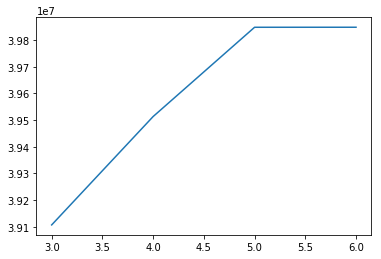

In [31]:
#plot llh to choose which number of modules I should go forward with
plt.plot([3, 4, 5, 6], [llh_max_1, llh_max_2, llh_max_3, llh_max_4])

Until we reach the true simulation R, the llh increases, but after that, there is not an improvement in the prediction. 

In [33]:
#row normalize after choosing best number of modules
#N, M, R, O = 100, 60, 5, 5 (parameters used to generate V_1)
R = 5
N = 100
denom = W_1.sum(1)
W_1_norm = np.zeros((R, N))
for i, s in enumerate(W_1.T):
    W_1_norm[i] = np.divide(s, denom)
    

denom = W_max_3.sum(1)
W_max_3_norm = np.zeros((R, N))
for i, s in enumerate(W_max_3.T):
    W_max_3_norm[i] = np.divide(s, denom)

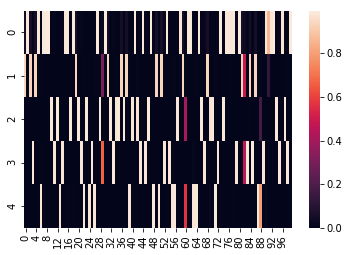

In [34]:
#plot W_max_3_norm
sns.heatmap(W_max_3_norm)

I plotted this because I wanted to see if I could see the moonlighting genes, and here you can see that I have 5 moonlighting genes which seem to match the numbers from the simulated data which are: 29 60 82 88 91 (rearranged from original output for ease of pointing out in the heatmap by eye).   

(array([395.,   2.,   0.,   1.,   3.,   1.,   1.,   0.,   2.,  95.]),
 array([4.82696708e-35, 9.94986392e-02, 1.98997278e-01, 2.98495917e-01,
        3.97994557e-01, 4.97493196e-01, 5.96991835e-01, 6.96490474e-01,
        7.95989113e-01, 8.95487752e-01, 9.94986392e-01]),
 <a list of 10 Patch objects>)

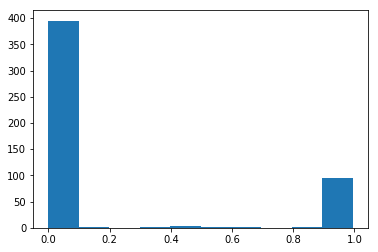

In [35]:
plt.hist(W_max_3_norm.flatten())

Checking to see if there is a threshold that I can set to identify moonlighting genes - looks like 0.1 is a good cutoff. 

In [36]:
print("number of genes in each module")
for i in range(R):
    print(len(np.where(W_max_3_norm[i] >= 0.1)[0]))

number of genes in each module
30
17
22
20
16


In [37]:
print("moonlighting genes:")
for i in range(N):
    if len(np.where(W_max_3_norm.T[i] >= 0.1)[0]) > 1:
        print(i)

moonlighting genes:
29
60
82
88
91


Voila! It matches! My code works - it actually reconstructs the synthetic data - Woo!

In [38]:
#vary number of moonlighting genes and R of the synthetic data here
#varying R, already tried 5 - that is W_1, H_1, V_1
#keep O the same
W_2a, H_2a, V_2a = simulator(100, 60, 3, 5)
W_3a, H_3a, V_3a = simulator(100, 60, 4, 5)
W_4a, H_4a, V_4a = simulator(100, 60, 6, 5)

number of genes in each module before moonlighting:
34
28
38
moonlighting genes:
[22 52 69 82 60]
moonlighting gene assignments
22 0 1
52 1 2
69 0 2
82 1 0
60 0 1
number of genes in each module after moonlighting:
35
30
40
number of genes in each module before moonlighting:
26
20
24
30
moonlighting genes:
[22 52 69 82 60]
moonlighting gene assignments
22 0 1
52 1 2
69 0 3
82 2 1
60 0 1
number of genes in each module after moonlighting:
26
23
25
31
number of genes in each module before moonlighting:
17
11
15
11
24
22
moonlighting genes:
[60 91 29 88 97]
moonlighting gene assignments
60 0 5
91 5 0
29 2 1
88 2 3
97 0 1
number of genes in each module after moonlighting:
18
13
15
12
24
23


In [61]:
llh_max_2a, W_max_2a, H_max_2a = NMF_max(V_2a, 3, 5)
llh_max_3a, W_max_3a, H_max_3a = NMF_max(V_2a, 4, 5)
llh_max_4a, W_max_4a, H_max_4a = NMF_max(V_2a, 5, 5)
llh_max_5a, W_max_5a, H_max_5a = NMF_max(V_2a, 6, 5)

39140350.086954206
39140454.569032334
39140473.04425371
39140529.18774286


The best R is 3 because it appears that the llh doesn't change very much at all. 

In [83]:
#row normalize after choosing best number of modules
#choose R
R = 3
N = V_2a.shape[0]

denom = W_max_2a.sum(1)
W_max_2a_norm = np.zeros((R, N))
for i, s in enumerate(W_max_2a.T):
    W_max_2a_norm[i] = np.divide(s, denom)

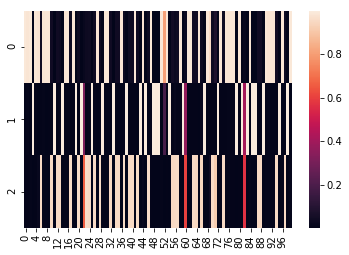

In [84]:
#plot W_max_A_norm
sns.heatmap(W_max_2a_norm)

(array([196.,   1.,   0.,   2.,   1.,   1.,   2.,   0.,   1.,  96.]),
 array([2.75514153e-08, 9.99996546e-02, 1.99999282e-01, 2.99998909e-01,
        3.99998536e-01, 4.99998163e-01, 5.99997790e-01, 6.99997417e-01,
        7.99997044e-01, 8.99996671e-01, 9.99996298e-01]),
 <a list of 10 Patch objects>)

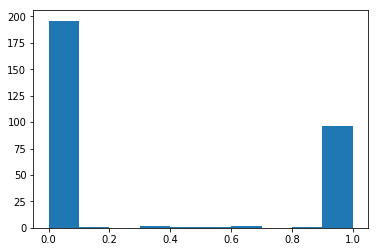

In [85]:
plt.hist(W_max_2a_norm.flatten())

Checking to see if there is a threshold that I can set to identify moonlighting genes - looks like 0.1 is a good cutoff. 

In [86]:
print("number of genes in each module")
for i in range(R):
    print(len(np.where(W_max_2a_norm[i] >= 0.1)[0]))

number of genes in each module
40
30
34


In [89]:
print("moonlighting genes:")
for i in range(N):
    if len(np.where(W_max_2a_norm.T[i] >= 0.07)[0]) > 1:
        print(i)

moonlighting genes:
22
52
60
71
82


Changing the number of modules doesn't alter the ability of my method to predict which are the moonlighting genes or the number of true modules.

# 3. Analyze the Adler data

In [41]:
Adler_df = pd.read_table("w10-data.tbl.txt", delim_whitespace = True, header = None, index_col = 0)

In [42]:
V = np.array(Adler_df)

In [43]:
llh_max_A, W_max_A, H_max_A = NMF_max(V, 3, 5)

38813520.027241014


In [44]:
llh_max_A2, W_max_A2, H_max_A2 = NMF_max(V, 4, 5)

39263115.78311299


In [45]:
llh_max_A3, W_max_A3, H_max_A3 = NMF_max(V, 5, 5)

39263165.91646238


In [46]:
llh_max_A4, W_max_A4, H_max_A4 = NMF_max(V, 6, 5)

39263216.449240685


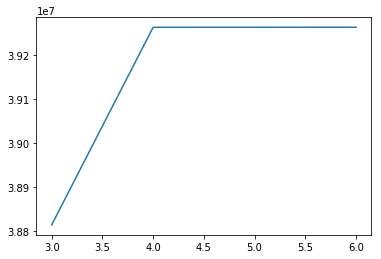

In [47]:
#plot llh to choose which number of modules I should go forward with
plt.plot([3, 4, 5, 6], [llh_max_A, llh_max_A2, llh_max_A3, llh_max_A4])

It seems that there are 4 modules in the Adler data.

In [50]:
#row normalize after choosing best number of modules
#choose R
R = 4
N = V.shape[0]

denom = W_max_A2.sum(1)
W_max_A2_norm = np.zeros((R, N))
for i, s in enumerate(W_max_A2.T):
    W_max_A2_norm[i] = np.divide(s, denom)

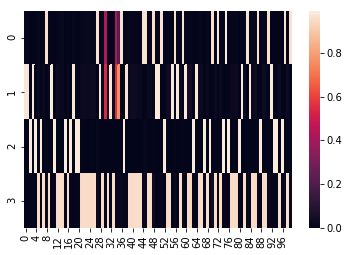

In [51]:
#plot W_max_A_norm
sns.heatmap(W_max_A2_norm)

Looks like there are three moonlighting genes between the gene indices 30 and 36. Hard to tell exactly what they are...let's figure it out quantitatively...

(array([297.,   0.,   1.,   0.,   2.,   2.,   0.,   1.,   0.,  97.]),
 array([7.54117409e-30, 9.91783035e-02, 1.98356607e-01, 2.97534911e-01,
        3.96713214e-01, 4.95891518e-01, 5.95069821e-01, 6.94248125e-01,
        7.93426428e-01, 8.92604732e-01, 9.91783035e-01]),
 <a list of 10 Patch objects>)

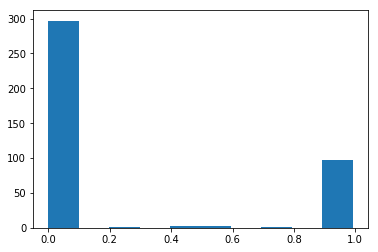

In [52]:
plt.hist(W_max_A2_norm.flatten())

Checking to see if there is a threshold that I can set to identify moonlighting genes - looks like 0.1 is a good cutoff for this dataset. 

In [53]:
print("number of genes in each module")
for i in range(R):
    print(len(np.where(W_max_A2_norm[i] >= 0.1)[0]))

number of genes in each module
20
20
20
43


In [54]:
Adler_df2 = pd.read_table("w10-data.tbl.txt", delim_whitespace = True, header = None)

In [55]:
print("moonlighting genes:")
for i in range(N):
    if len(np.where(W_max_A2_norm.T[i] >= 0.1)[0]) > 1:
        print(i)
        print(Adler_df2.iloc[i][0])

moonlighting genes:
30
currant
34
fennel
35
fig
